In [1]:
import numpy as np
import os, sys

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import zarr

from utils import remove_all_ticks_and_labels

I want to train a 10 neuron model for a 3d manifold. 

size of the training set is 2000
torch.Size([2000, 10])
size of the training set is 2000


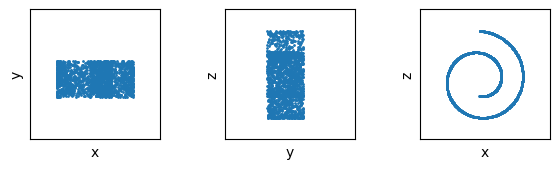

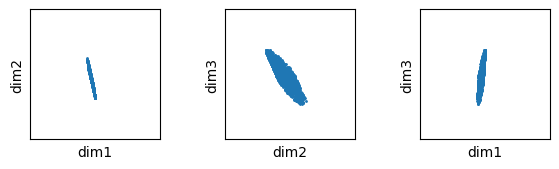

In [2]:
# dataset
from dataset_utils import load_unimodal_data_nd

n_points = int(2e3)

# 2D dataset (not rotated)
dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=0, noise=0, shrink_y_axis=True)
print(dataset.shape)

lim=1.5
lims=[-lim, lim]
fig, axes = plt.subplots(1, 3, figsize=(6, 2))
ax = axes[0]
ax.scatter(*dataset[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='x', ylabel='y')

ax = axes[1]
ax.scatter(*dataset[:, 1:3].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='y', ylabel='z')

ax = axes[2]
ax.scatter(*dataset[:, (0,2)].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='x', ylabel='z')
fig.tight_layout()
for ax in axes:
    remove_all_ticks_and_labels(ax)


# rotated dataset
dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)
fig, axes = plt.subplots(1, 3, figsize=(6, 2))
ax = axes[0]
ax.scatter(*dataset[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='dim1', ylabel='dim2')

ax = axes[1]
ax.scatter(*dataset[:, 1:3].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='dim2', ylabel='dim3')

ax = axes[2]
ax.scatter(*dataset[:, (0,2)].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='dim1', ylabel='dim3')
fig.tight_layout()
for ax in axes:
    remove_all_ticks_and_labels(ax)

(2000, 2)
[0.49636423 0.41214746]
[27.57687002 25.1287593 ]
[[-0.03228296  0.12877785  0.00374683 -0.52922671  0.56590311  0.09652437
  -0.096953    0.00956814  0.22586365  0.55875757]
 [ 0.0696991  -0.31178966  0.36658166  0.19244511 -0.4432345  -0.02687535
   0.17216397  0.18452062  0.26395947  0.62926148]]


[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

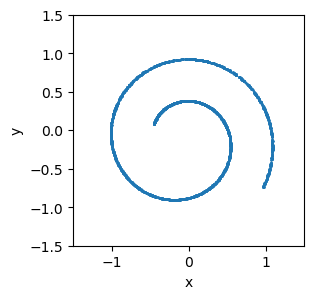

In [3]:
# performing PCA on the rotated dataset
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(dataset)
dataset_2d =pca.transform(dataset)
print(dataset_2d.shape)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_)

# plotting the PCA
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(*dataset_2d[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='x', ylabel='y')

this is what we want the generated samples to look like.

In [6]:
# now train model on the 10D dataset
from prior_utils import forward_process
from utils import noise_estimation_loss
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time

def reverse_process(model, 
                    model_name, 
                    model_number, 
                    num_steps, 
                    num_hidden, 
                    num_dims,
                    num_epochs,
                    batch_size,
                    lr,
                    device,
                    dataset,
                    pretrained_model):
    
    # beta-related parameters
    coefs = forward_process(num_steps, device)
    betas, alphas, alphas_prod, alphas_prod_p, alphas_bar_sqrt, one_minus_alphas_prod_log, one_minus_alphas_prod_sqrt = coefs
    alphas_bar_sqrt = alphas_bar_sqrt.to(device)
    one_minus_alphas_prod_sqrt = one_minus_alphas_prod_sqrt.to(device)
    
    # training set
    dataset = dataset.to(device)
    
    # define model
    if pretrained_model['use_pretrained_model_weights']:
        from utils import load_model_weights
        pretrained_model_name = pretrained_model['model_name']
        pretrained_model_num = pretrained_model['model_num']
        print(f'taking weights from pretrained model {pretrained_model_name}_{pretrained_model_num}!')
        model = load_model_weights(model, pretrained_model_name, pretrained_model_num, device)
    model.to(device)

    # training parameteres
    optimizer = optim.Adam(model.parameters(), lr=lr)

    run_dir = os.path.join(base_dir, 'demos/runs', f'{model_name}_{model_number}')
    tb = SummaryWriter(run_dir)
    start_time = time.time()
    
    # start training
    model.train()
    for t in trange(int(num_epochs), desc='Training model', unit='epochs'):
        permutation = torch.randperm(dataset.size()[0], device=device)
    
        for i in range(0, dataset.size()[0], batch_size):
            # retrieve current batch
            indices = permutation[i:i+batch_size]
            batch_x = dataset[indices]
            
            # compute the loss
            loss = noise_estimation_loss(model, batch_x, num_steps, alphas_bar_sqrt, one_minus_alphas_prod_sqrt, device, norm='l2', has_class_label=False)
            # zero the gradients
            optimizer.zero_grad()
            # backward pass: compute the gradient of the loss wrt the parameters
            loss.backward()
            # call the step function to update the parameters
            optimizer.step()
        
        # write to tensorboard
        tb.add_scalar('Loss', loss.item(), t)
    tb.flush()

    end_time = time.time()
    duration = end_time - start_time
    duration_mins = duration / 60
    print(f'training took {duration:.0f} seconds, which is {duration_mins:.2f} minutes.')
    return model

In [7]:
import json
from models import VariableDendriticCircuit

# define hyperparameter values
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# -------------------------- set model parameters -------------------------- #
model_name = 'unconditional-dendritic'
model_number = 56
num_steps = 100
num_hidden = [3, 3, 3, 3, 3, 3, 4]
num_ambient_dims = 10
num_samples_in_training_set = 1e3
epochs = 3e5
manifold_type = 'swiss_roll_3d'
batch_size = 128
lr = 1e-4
pretrained_model = {
    'use_pretrained_model_weights': True,
    'model_name': 'unconditional-dendritic',
    'model_num': 55
}


# -------------------------- save model description -------------------------- #
description = {
    'model_name': model_name,
    'model_number': model_number,
    'num_steps': num_steps,
    'num_hidden': num_hidden,
    'num_ambient_dims': num_ambient_dims,
    'num_samples_in_training_set': f'{num_samples_in_training_set:.0e}',
    'num_epochs': f'{epochs:.0e}',
    'manifold_type': manifold_type,
    'batch_size': batch_size,
    'learning_rate': f'{lr:.0e}',
    'use_pretrained_model': pretrained_model['use_pretrained_model_weights'],
}
if pretrained_model['use_pretrained_model_weights']:
    description['pretrained_model_name'] = pretrained_model['model_name']
    description['pretrained_model_num'] = pretrained_model['model_num']

json_savedir = os.path.join(base_dir, 'core/model_description')
model_name_and_number = f'{model_name}_{model_number}'
json_name = f'{model_name_and_number}.json'
with open(os.path.join(json_savedir, json_name), 'w') as file:
    json.dump(description, file)


from models import VariableDendriticCircuit
model = VariableDendriticCircuit(hidden_cfg=num_hidden, num_in=num_ambient_dims, num_out=num_ambient_dims, bias=True)
dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)

# -------------------- TRAINING - reverse diffusion process ------------------ #
model = reverse_process(model, model_name, model_number, num_steps, num_hidden, num_ambient_dims, epochs, batch_size, lr, device, dataset, pretrained_model)
from utils import save_model_weights
save_model_weights(model, model_name, model_number)

Using device: cuda
size of the training set is 2000
taking weights from pretrained model unconditional-dendritic_55!
model loaded!


Training model:   0%|          | 0/300000 [00:00<?, ?epochs/s]

training took 16849 seconds, which is 280.82 minutes.
model state dict saved in directory: /mnt/ceph/users/blyo1/projects/LyoSavin2023/core/saved_weights/unconditional-dendritic_56.pt


Using device: cuda
model loaded!
torch.Size([101, 1000, 10])


[(-1.5, 1.5), (-1.5, 1.5), None]

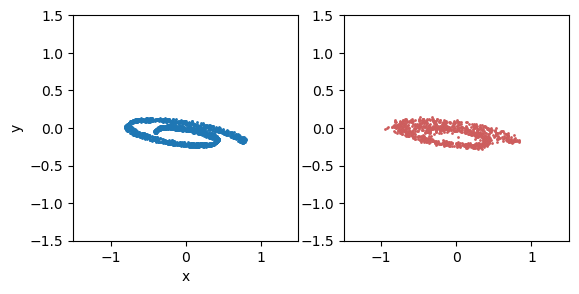

In [8]:
# compare the model output vs ground truth dataset
dim1 = 4
dim2 = 7

# load model and weights
global device
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

from utils import select_model
model, num_steps, dim_amb = select_model('unconditional-dendritic', 55)
model = model.to(device)

fig, ax = plt.subplots(1, 2)
ax[0].scatter(*dataset[:, (dim1, dim2)].T, s=1)
ax[0].set(xlim=lims, ylim=lims, aspect='equal')
ax[0].set(xlabel='x', ylabel='y')

from prior_utils import p_sample_loop
sample_size = int(1e3)
x_seq = p_sample_loop(model, (sample_size, dim_amb), 100, device=device, init_x=None, normalized_beta_schedule=False)
print(x_seq.shape)


cur_x = x_seq[100].detach().cpu()
ax[1].scatter(cur_x[:, dim1], cur_x[:, dim2],color='white',edgecolor='indianred', s=1)
ax[1].set(xlim=lims, ylim=lims, aspect='equal')


(1000, 2)


[(-1.5, 1.5), (-1.5, 1.5), None]

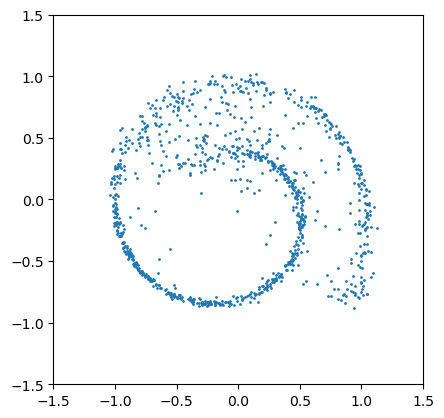

In [22]:
# now perform PCA on the model output
model_output = x_seq[100].detach().cpu()

pca = PCA(n_components=2)
pca.fit(model_output)
x_seq_2d = pca.transform(model_output)
print(x_seq_2d.shape)

fig, ax = plt.subplots(1, 1)
ax.scatter(*x_seq_2d[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')



I want to check how the discretization affects the quality of the samples. Does it at all? 

How does the sample quality change over learning?